## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell

cp "/content/drive/MyDrive/Colab Notebooks/GAN Application/GAN_data.zip" .
unzip GAN_data.zip
rm GAN_data.zip

Archive:  GAN_data.zip
   creating: GAN_data/
   creating: GAN_data/disp_noc/
  inflating: __MACOSX/GAN_data/._disp_noc  
  inflating: GAN_data/.DS_Store      
  inflating: __MACOSX/GAN_data/._.DS_Store  
   creating: GAN_data/data1/
  inflating: __MACOSX/GAN_data/._data1  
   creating: GAN_data/data2/
  inflating: __MACOSX/GAN_data/._data2  
   creating: GAN_data/data3/
  inflating: __MACOSX/GAN_data/._data3  
   creating: GAN_data/disp_noc/disp_noc_0/
  inflating: __MACOSX/GAN_data/disp_noc/._disp_noc_0  
   creating: GAN_data/disp_noc/disp_noc_1/
  inflating: __MACOSX/GAN_data/disp_noc/._disp_noc_1  
  inflating: GAN_data/data1/.DS_Store  
  inflating: __MACOSX/GAN_data/data1/._.DS_Store  
   creating: GAN_data/data1/train/
  inflating: __MACOSX/GAN_data/data1/._train  
   creating: GAN_data/data1/val/
  inflating: __MACOSX/GAN_data/data1/._val  
  inflating: GAN_data/data2/.DS_Store  
  inflating: __MACOSX/GAN_data/data2/._.DS_Store  
   creating: GAN_data/data2/train/
  inflating:

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.activations as activations
import matplotlib.pyplot as plt
#import tensorflow_probability as tfp

from IPython.display import clear_output
from tensorflow.keras.applications.vgg19 import VGG19
print(tf.__version__)

2.12.0


## Configs

In [ ]:
PATH = '/content/GAN_data/data1'

BUFFER_SIZE = 20
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

LOW_WIDTH   = 256
LOW_HEIGHT  = 64

## Prepare Data

In [ ]:
def load(image_path):
    """
    Parameters
    ----------
    image_path : string
        Path dẫn đến file ảnh.

    Returns
    -------
    image_lr: tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr: tf.Tensor (tf.float32)
        ảnh target low resolution không bị nhiễu
    target_hr: tf.Tensor (tf.float32)
        ảnh target high resolution
    """

    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img)

    image_lr = tf.image.resize(img, (LOW_HEIGHT, LOW_WIDTH))
    target_lr = tf.image.resize(img, (LOW_HEIGHT, LOW_WIDTH))
    target_hr = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    noise_per = 0.20
    noise = tf.random.uniform(shape=(LOW_HEIGHT,LOW_WIDTH,3), minval=1-noise_per, maxval=1+noise_per)

    # noise = tf.random.uniform(shape=(LOW_HEIGHT,LOW_WIDTH,3), minval=0, maxval=1)

    image_lr = tf.cast(image_lr, dtype=tf.float32)
    target_lr = tf.cast(target_lr, dtype=tf.float32)
    target_hr = tf.cast(target_hr, dtype=tf.float32)

    image_lr = image_lr * noise
    image_lr = tf.clip_by_value(image_lr, 0, 255)

    return image_lr, target_lr, target_hr

(64, 256, 3)
(64, 256, 3)
(256, 1024, 3)


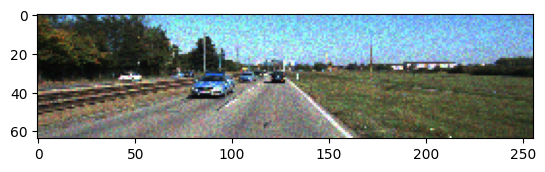

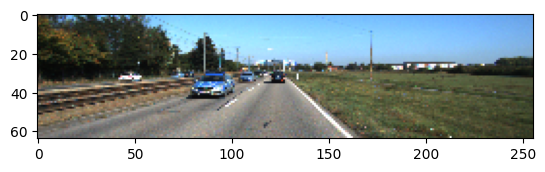

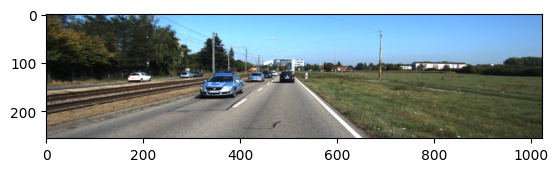

In [ ]:
image_lr, target_lr, target_hr = load(PATH+'/train/000040_10.png')
print(image_lr.shape)
print(target_lr.shape)
print(target_hr.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(image_lr/255.0)
plt.figure()
plt.imshow(target_lr/255.0)
plt.figure()
plt.imshow(target_hr/255.0)
plt.show()

In [ ]:
def normalize(image_lr, target_lr, target_hr):
    """
    Parameters
    ----------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution
    """

    image_lr = image_lr/127.5 - 1
    target_lr = target_lr/127.5 - 1
    target_hr = target_hr/127.5 - 1

    return image_lr, target_lr, target_hr

#@tf.function()
def random_jitter(image_lr, target_lr, target_hr):
    """
    Parameters
    ----------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution
    """
    prob = np.random.random()
    if prob > 0.5:
        image_lr = tf.image.flip_left_right(image_lr)
        target_lr = tf.image.flip_left_right(target_lr)
        target_hr = tf.image.flip_left_right(target_hr)

    return image_lr, target_lr, target_hr


def load_image_train(image_path):
    """
    Parameters
    ----------
    image_path    : string
        path nơi chứa ảnh data

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution
    """

    image_lr, target_lr, target_hr = load(image_path)
    image_lr, target_lr, target_hr = random_jitter(image_lr, target_lr, target_hr)
    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr



def load_image_test(image_path):
    """
    Parameters
    ----------
    image_path    : string
        path nơi chứa ảnh data

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32)
        ảnh target low resolution
    target_hr    : tf.Tensor (tf.float32)
        ảnh target high resolution
    """
    image_lr, target_lr, target_hr = load(image_path)
    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'/val/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Model

### Blocks

In [ ]:
def extract_first_features(filters, size, apply_batchnorm=True):
    """
    Parameters
    ----------
    filters         : int
        số lượng filters
    size            : int
        size của filter
    apply_batchnorm : bool
        có sử dụng batchnorm hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        block CONV2D -> BN(bool) -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters=filters, kernel_size=size, padding='same'))
    if apply_batchnorm == True:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def downsample(filters, size, apply_batchnorm=True):
    """
    Parameters
    ----------
    filters         : int
        số lượng filters
    size            : int
        size của filter
    apply_batchnorm : bool
        có sử dụng batchnorm hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        block CONV2D -> BN(bool) -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters=filters, kernel_size=size, padding='same', strides=2))
    if apply_batchnorm == True:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result



def downsample_dis(filters, size_12, size_3, apply_batchnorm=True):
    """
    Parameters
    ----------
    filters         : int
        số lượng filters
    size_12         : int
        kernel size cho CONV2D 1 và 2
    size_3          : int
        kernel size cho CONV2D 3
    apply_batchnorm : bool
        có sử dụng batchnorm hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        CONV2D -> CONV2D -> CONV2D -> BN(bool) -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters=filters, kernel_size=size_12, padding='same'))
    result.add(layers.Conv2D(filters=filters, kernel_size=size_12, padding='same'))
    result.add(layers.Conv2D(filters=filters, kernel_size=size_3, strides=2, padding='same'))
    if apply_batchnorm == True:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    """
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_dropout : bool
        có sử dụng Dropout hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2, padding='same'))
    result.add(layers.BatchNormalization())
    if apply_dropout == True:
        result.add(layers.Dropout(rate=0.2))
    result.add(layers.ReLU())

    return result

def downsample_sr(filters, size, apply_batchnorm=True):
    """
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_batchnorm : bool
        có sử dụng Dropout hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2D -> BN -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters=filters, kernel_size=size, padding='same'))
    if apply_batchnorm == True:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def upsample_sr(filters, size, apply_dropout=False):
    """
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_dropout : bool
        có sử dụng Dropout hay không
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    """

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2, padding='same'))
    result.add(layers.BatchNormalization())
    if apply_dropout == True:
        result.add(layers.Dropout(rate=0.5))
    result.add(layers.LeakyReLU())

    return result

### Generator

In [ ]:

def UNet_process(x):
    """
    Parameters
    ----------
    x: tensor
        feature ảnh input
    Returns
    -------
    x: tensor
        ảnh xóa nhiễu
    """

    down_stack = [
        downsample(filters=64, size=4, apply_batchnorm=False),
        downsample(filters=256, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
    ]

    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=256, size=4, apply_dropout=True),
        upsample(filters=64, size=4, apply_dropout=False),
    ]

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                             strides=2, padding='same', activation='tanh')

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return x


def Generator():
    """
    model: tf.keras.models.Model
        model tạo ảnh xóa nhiễu và ảnh super resolution (x4)
    """

    # tạo layer input với shape = input low resolution image (có nhiễu)
    inputs = layers.Input(shape=(LOW_HEIGHT, LOW_WIDTH, 3))

    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(inputs)

    x = UNet_process(x)
    fake_lr = x

    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(x)

    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)

    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)

    x = upsample_sr(filters=128, size=4, apply_dropout=False)(x)

    x = downsample_sr(filters=128, size=3, apply_batchnorm=True)(x)

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                             strides=2, padding='same', activation='tanh')

    fake_hr = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=[fake_lr, fake_hr])

    return model

In [ ]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 64, 256, 64)  2048        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 128, 64)  65600       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 64, 256)  263424      ['sequential_1[0][0]']       

### Discriminator

In [ ]:
def Discriminator1():
    """
    model: tf.keras.models.Model
        model phân loại ảnh sau khi xóa nhiễu của model và ảnh targe_lr có giống nhau hay không
        generator có đánh lừa được discriminator
    """
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[LOW_HEIGHT, LOW_WIDTH, 3])
    tar = tf.keras.layers.Input(shape=[LOW_HEIGHT, LOW_WIDTH, 3])
    x = layers.concatenate([inp, tar])

    x = downsample(filters=64, size=4)(x)
    x = downsample(filters=128, size=4)(x)
    x = downsample(filters=256, size=4)(x)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(x)
    conv = layers.Conv2D(256, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    model = tf.keras.Model(inputs=[inp, tar], outputs=last)

    return model

def Discriminator2():
    """
    model: tf.keras.models.Model
        model phân loại ảnh sau khi model thực hiện tạo ra ảnh super resolution và ảnh targe_lr có giống nhau hay không
        generator có đánh lừa được discriminator2
    """
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    x = downsample(filters=64, size=4)(inp)
    x = downsample(filters=128, size=4)(x)
    x = downsample(filters=256, size=4)(x)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(x)
    conv = layers.Conv2D(256, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    model = tf.keras.Model(inputs=inp, outputs=last)

    return model

In [ ]:
discriminator1 = Discriminator1()
discriminator2 = Discriminator2()

In [ ]:
discriminator1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 64, 256, 6)   0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
discriminator2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 1024, 3)]    0         
                                                                 
 sequential_18 (Sequential)  (None, 128, 512, 64)      3392      
                                                                 
 sequential_19 (Sequential)  (None, 64, 256, 128)      131712    
                                                                 
 sequential_20 (Sequential)  (None, 32, 128, 256)      525568    
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 34, 130, 256)     0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 31, 127, 256)      1048576   
                                                           

## Compile & Train

### Loss

#### Discriminator Loss

In [ ]:
# Khai báo BCE loss
loss_dsic_object = losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.03)
def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Parameters
    ----------
    disc_real_output         : tf.float32 (tensor)
        Kết quả khi target đi qua discriminator
    disc_generated_output    : tf.float32 (tensor)
        Kết quả khi fake image  đi qua discriminator
    -------
    total_loss: tf.float32
        loss tổng của discriminator
    """

    disc_real_loss = loss_dsic_object(tf.ones_like(disc_real_output), disc_real_output)
    disc_generated_loss = loss_dsic_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_loss = disc_real_loss + disc_generated_loss
    return total_loss

#### Generator Loss

In [ ]:
class PeceptualLoss():
    def __init__(self, input_shape):
        self.layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        self.extractor = self.get_extractor(input_shape)
        self.MSE = tf.keras.losses.MeanSquaredError()
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input


    def get_extractor(self, input_shape):
        vgg = tf.keras.applications.VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in self.layer_names]
        model = tf.keras.models.Model(inputs=vgg.input, outputs=outputs)

        return model


    def percep_loss(self, target_image, fake_image):

        target_image = (target_image*0.5 + 0.5)*255
        fake_image = (fake_image*0.5 + 0.5)*255

        target_image = self.vgg_preprocessing(target_image)
        fake_image = self.vgg_preprocessing(fake_image)

        target_features = self.extractor(target_image)
        fake_features = self.extractor(fake_image)
        scaled = [1/14, 1/20, 2*1/30, 1/1.5, 20]
        loss = 0
        for  sc, tar_fea, fk_fea in zip(scaled, target_features, fake_features):
            loss += sc*tf.reduce_mean(tf.abs(tar_fea-fk_fea))

        loss= loss/len(fake_features)
        return loss

per_loss = PeceptualLoss(input_shape=(None, None, 3))

def content_loss(img1, img2):
    loss = per_loss.percep_loss(img1, img2)
    return loss

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
LAMBDA_1 = 0.25
LAMBDA_2 = 20

loss_gener1_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_gener2_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss1(disc_generated_output, disc_real_output, gen_output, target):
    """
    Parameters
    ----------
    disc_generated_output         : tf.float32 (tensor)
        Kết quả khi ảnh low resolution (xóa nhiễu) đi qua discriminator
    gen_output    : tf.float32 (tensor)
        Kết quả ảnh low resolution được tạo ra
    target        : tf.float32
        Ảnh targe low resolution
    -------
    total_loss: tf.float32
        loss tổng của generator phần denoise
    gan_loss: tf.float32
        loss gan phần denoise
    l1_loss: tf.float32
        l1 loss generator phần denoise
    """

    gan_loss = loss_gener1_object(tf.ones_like(disc_generated_output), disc_generated_output)

    perceptual_loss = content_loss(gen_output, target)

    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

    total_loss = gan_loss + LAMBDA_1 * perceptual_loss + LAMBDA_2 * l1_loss

    return total_loss, gan_loss, perceptual_loss, l1_loss


def generator_loss2(disc_generated_output, disc_real_output, gen_output, target):
    """
    Parameters
    ----------
    disc_generated_output         : tf.float32 (tensor)
        Kết quả khi ảnh high resolution được tạo từ model  đi qua discriminator
    gen_output    : tf.float32 (tensor)
        Kết quả ảnh high resolution được tạo ra
    target        : tf.float32
        Ảnh targe high resolution
    -------
    total_loss: tf.float32
        loss tổng của generator phần super resolution
    gan_loss: tf.float32
        loss gan phần super resolution
    l1_loss: tf.float32
        l1 loss generator phần super resolution
    """

    gan_loss = loss_gener1_object(tf.ones_like(disc_generated_output), disc_generated_output)

    perceptual_loss = content_loss(gen_output, target)

    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

    total_loss = gan_loss + LAMBDA_1 * perceptual_loss + LAMBDA_2 * l1_loss

    return total_loss, gan_loss, perceptual_loss, l1_loss

### Optimizers

In [ ]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)

### Config Checkpoint

In [ ]:
checkpoint_dir = 'checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator1_optimizer=discriminator1_optimizer,
                                 discriminator2_optimizer=discriminator2_optimizer,
                                 generator=generator,
                                 discriminator1=discriminator1,
                                 discriminator2=discriminator2)

### Evaluation and Show Result Functions

In [ ]:
def evaluate(model, image_lr, target_sr):
    _, fake_hr = model([image_lr], training=False)

    psnr = tf.image.psnr(fake_hr, target_sr, max_val=1.0)

    psnr_mean = tf.math.reduce_mean(psnr)

    print('-------- psnr: ', psnr_mean.numpy())

    return psnr_mean


def generate_images(model, image_lr, target_sr):
    _, fake_hr = model([image_lr], training=False)

    display_list = [image_lr[0], target_sr[0], fake_hr[0]]
    title_l = ['Input', 'Real', 'Generated']
    plt.figure(figsize=(25,25))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title_l[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Train Function

In [ ]:
@tf.function
def train_step(image_lr, target_lr, target_hr):
    """
    Parameters
    ----------
    image_lr         : tf.float32
        Ảnh low resolution và nhiễu
    target_lr        : tf.float32
        target low resolution
    target_hr        : tf.float32
        Ảnh targe high resolution
    -------
    gan_loss: tf.float32
        loss tổng của generator loss
    l1_loss: tf.float32
        loss gan phần super resolution
    disc_loss: tổng discriminator loss

    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:
        fake_lr, fake_hr = generator(image_lr, training=True)

        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)

        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)

        total_lr_loss, gan_lr_loss, perceptual_lr_loss, l1_lr_loss = generator_loss1(disc_lr_generated_output, disc_lr_real_output, fake_lr, target_lr)
        total_hr_loss, gan_hr_loss, perceptual_hr_loss, l1_hr_loss = generator_loss2(disc_hr_generated_output, disc_hr_real_output, fake_hr, target_hr)

        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)

        gan_loss = gan_lr_loss + gan_hr_loss
        perceptual_loss = perceptual_lr_loss + perceptual_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss

        total_gen_loss = total_lr_loss + total_hr_loss

    generator_grads = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_grads = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_grads = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_grads, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_grads, discriminator2.trainable_variables))

    return gan_loss, perceptual_loss, l1_loss, disc_loss


def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):
        start = time.time()

        # Train
        for image_lr, target_lr, target_hr in train_ds:
#
            gan_loss, perceptual_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)

        psnr = evaluate(generator, image_lr, target_hr)
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr

            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        print('epoch {}  gan_loss: {}  perceptual_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, perceptual_loss, l1_loss, disc_loss))

### Train

In [23]:
EPOCHS = 150
fit(train_dataset, EPOCHS, test_dataset)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
%%shell
cp -r "/content/checkpoints" "/content/drive/MyDrive/Colab Notebooks/GAN Application/Full source code"